<div style="text-align: center;">
    <h1>Regression of Used Car Prices</h1>
</div>

## Índice

- [1 - Preparación de Datos](#preparaciondedatos)
- [1.1 - Carga de Datos](#cargadedatos)
- [2 - Transformación de Datos](#transformaciondedatos)
- [3 - Exploración de los Datos](#exploraciondedatos)

### 1 - Preparación de Datos <a name="preparaciondedatos"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import xgboost as xgb
import lightgbm as lgb
import optuna
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')


/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
# Se define función que cuenta la cantidad de valores nulos en cada columna de un DataFrame y se calcula
# el porcentaje de valores nulos por columna.

def contar_valores_nulos_con_porcentaje(dataframe):

    nulos_por_columna = dataframe.isnull().sum()
    porcentaje_nulos_por_columna = (nulos_por_columna / len(dataframe)) * 100

    resultados = pd.DataFrame({
        'Cantidad de Nulos': nulos_por_columna,
        'Porcentaje de Nulos (%)': porcentaje_nulos_por_columna
    })

    return resultados

#Se define función que elimina los valores atípicos de una columna específica en un DataFrame.
#La misma utiliza el método de rango intercuartílico para identificar valores atípicos, que son aquellos puntos de datos
#que caen fuera del rango definido por el primer cuartil (Q1) y el tercer cuartil (Q3).

def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_filtered = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    return df_filtered

#Se define función que elimina iterativamente los valores atípicos de una columna específica en un DataFrame hasta que
#no se encuentren más valores atípicos según el criterio del rango intercuartílico definido en la función "remove_outliers".

def remove_outliers_iteratively(df, column_name):
    df_clean = df.copy()
    while True:
        initial_len = len(df_clean)
        df_clean = remove_outliers(df_clean, column_name)
        final_len = len(df_clean)
        if initial_len == final_len:
            break
    return df_clean

In [3]:
def count_outliers(df, column):
    """
    Cuenta el número de valores atípicos en una columna específica de un DataFrame.

    Args:
    df (pandas.DataFrame): El DataFrame que contiene los datos.
    column (str): El nombre de la columna en la que se contarán los valores atípicos.

    Returns:
    int: El número de valores atípicos en la columna especificada.
    """
    # Calcular Q1 (primer cuartil), Q3 (tercer cuartil) y el IQR (rango intercuartílico)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Definir los límites para los valores atípicos
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Contar los valores atípicos
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    num_outliers = outliers.shape[0]

    return num_outliers

#### 1.1 - Carga de Datos <a name="cargadedatos"></a>

In [4]:
train_df = pd.read_csv('train.csv') 
test_df = pd.read_csv('test.csv')  
sample_submission = pd.read_csv('sample_submission.csv')

### Preparación de Datos

In [5]:
train_df.head(5)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [7]:
test_df.head(5)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            125690 non-null  int64 
 1   brand         125690 non-null  object
 2   model         125690 non-null  object
 3   model_year    125690 non-null  int64 
 4   milage        125690 non-null  int64 
 5   fuel_type     122307 non-null  object
 6   engine        125690 non-null  object
 7   transmission  125690 non-null  object
 8   ext_col       125690 non-null  object
 9   int_col       125690 non-null  object
 10  accident      124058 non-null  object
 11  clean_title   111451 non-null  object
dtypes: int64(3), object(9)
memory usage: 11.5+ MB


### 2 - Transformación de Datos <a name="transformaciondedatos"></a>

In [9]:
# Selecciona todas las columnas del DataFrame 'train_df' que son de tipo 'object'
object_cols = train_df.select_dtypes(include=['object']).columns

# Crea un diccionario vacío que almacenará los LabelEncoders para cada columna.
label_encoders = {}

# Itera sobre cada columna categórica seleccionada
for col in object_cols:
    # Crea una instancia de LabelEncoder, que convierte las categorías en números.
    le = LabelEncoder()
    # Aplica LabelEncoder a la columna correspondiente, luego, guarda los valores transformados en una nueva columna en 'train_df' con el sufijo '_encoded' para distinguirla de la columna original.
    train_df[col + '_encoded'] = le.fit_transform(train_df[col].astype(str))
    # Guarda el LabelEncoder utilizado para esta columna en el diccionario 'label_encoders', con la clave siendo el nombre de la columna original.
    label_encoders[col] = le  


In [10]:
# Selecciona todas las columnas del DataFrame 'test_df' que son de tipo 'object'
object_cols = test_df.select_dtypes(include=['object']).columns

# Crea un diccionario vacío que almacenará los LabelEncoders para cada columna.
label_encoders = {}

# Itera sobre cada columna categórica seleccionada
for col in object_cols:
    # Crea una instancia de LabelEncoder, que convierte las categorías en números.
    le = LabelEncoder()
    # Aplica LabelEncoder a la columna correspondiente, luego, guarda los valores transformados en una nueva columna en 'test_df' con el sufijo '_encoded' para distinguirla de la columna original.
    test_df[col + '_encoded'] = le.fit_transform(test_df[col].astype(str))
    # Guarda el LabelEncoder utilizado para esta columna en el diccionario 'label_encoders', con la clave siendo el nombre de la columna original.
    label_encoders[col] = le  


In [11]:
# Se visualizan la cantidad de valores nulos por columna para luego evaluar los pasos a seguir.
contar_valores_nulos_con_porcentaje(train_df)

,Cantidad de Nulos,Porcentaje de Nulos (%)
id,0,0.000000
brand,0,0.000000
model,0,0.000000
model_year,0,0.000000
milage,0,0.000000
fuel_type,5083,2.696080
engine,0,0.000000
transmission,0,0.000000
ext_col,0,0.000000
int_col,0,0.000000


In [12]:
train_df['clean_title'].value_counts()

clean_title
Yes    167114
Name: count, dtype: int64

In [13]:
# Encontrar el valor más frecuente en la columna 'clean_title'
most_frequent = train_df['clean_title'].value_counts().idxmax()

# Reemplazar los valores nulos con el valor más frecuente
train_df['clean_title'] = train_df['clean_title'].fillna(most_frequent)


In [14]:
train_df['accident'].value_counts()

accident
None reported                             144514
At least 1 accident or damage reported     41567
Name: count, dtype: int64

In [15]:
# Encontrar el valor más frecuente en la columna 'accident'
most_frequent = train_df['accident'].value_counts().idxmax()

# Reemplazar los valores nulos con el valor más frecuente
train_df['accident'] = train_df['accident'].fillna(most_frequent)


In [16]:
train_df['fuel_type'].value_counts()

fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64

In [17]:
# Encontrar el valor más frecuente en la columna 'fuel_type'
most_frequent = train_df['fuel_type'].value_counts().idxmax()

# Reemplazar los valores nulos con el valor más frecuente
train_df['fuel_type'] = train_df['fuel_type'].fillna(most_frequent)


In [18]:
# Se visualizan la cantidad de valores nulos por columna para luego evaluar los pasos a seguir.
contar_valores_nulos_con_porcentaje(test_df)

,Cantidad de Nulos,Porcentaje de Nulos (%)
id,0,0.000000
brand,0,0.000000
model,0,0.000000
model_year,0,0.000000
milage,0,0.000000
fuel_type,3383,2.691543
engine,0,0.000000
transmission,0,0.000000
ext_col,0,0.000000
int_col,0,0.000000


In [19]:
test_df['clean_title'].value_counts()

clean_title
Yes    111451
Name: count, dtype: int64

In [20]:
# Encontrar el valor más frecuente en la columna 'clean_title'
most_frequent = test_df['clean_title'].value_counts().idxmax()

# Reemplazar los valores nulos (NaN) con el valor más frecuente
test_df['clean_title'] = test_df['clean_title'].fillna(most_frequent)


In [21]:
test_df['accident'].value_counts()

accident
None reported                             96263
At least 1 accident or damage reported    27795
Name: count, dtype: int64

In [22]:
# Encontrar el valor más frecuente en la columna 'accident'
most_frequent = test_df['accident'].value_counts().idxmax()

# Reemplazar los valores nulos con el valor más frecuente
test_df['accident'] = test_df['accident'].fillna(most_frequent)


In [23]:
test_df['fuel_type'].value_counts()

fuel_type
Gasoline          110533
Hybrid              4676
E85 Flex Fuel       3523
Diesel              2686
–                    538
Plug-In Hybrid       337
not supported         14
Name: count, dtype: int64

In [24]:
# Encontrar el valor más frecuente en la columna 'fuel_type'
most_frequent = test_df['fuel_type'].value_counts().idxmax()

# Reemplazar los valores nulos con el valor más frecuente
test_df['fuel_type'] = test_df['fuel_type'].fillna(most_frequent)


### 3 - Exploración de los Datos <a name="exploraciondedatos"></a>

In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    188533 non-null  int64 
 1   brand                 188533 non-null  object
 2   model                 188533 non-null  object
 3   model_year            188533 non-null  int64 
 4   milage                188533 non-null  int64 
 5   fuel_type             188533 non-null  object
 6   engine                188533 non-null  object
 7   transmission          188533 non-null  object
 8   ext_col               188533 non-null  object
 9   int_col               188533 non-null  object
 10  accident              188533 non-null  object
 11  clean_title           188533 non-null  object
 12  price                 188533 non-null  int64 
 13  brand_encoded         188533 non-null  int64 
 14  model_encoded         188533 non-null  int64 
 15  fuel_type_encoded

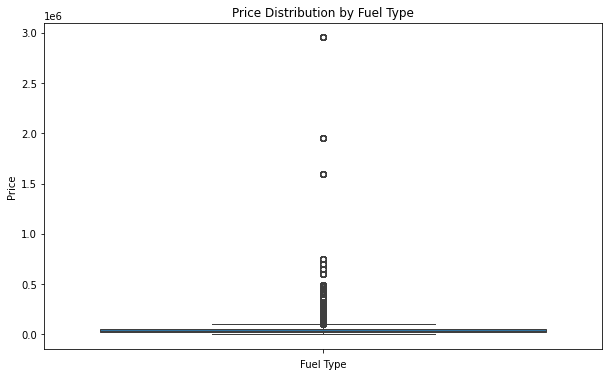

In [26]:
# En funcion del precio, se visualizan outliers.
plt.figure(figsize=(10, 6))
sns.boxplot(y='price', data=train_df)
plt.title('Price Distribution by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Price')
plt.show()

In [27]:
# Se encuentran 10.880 outliers sobre 188.533 valores.
count_outliers(train_df, 'price')

10880

In [28]:
# train_df = remove_outliers_iteratively(train_df, 'price')

El histograma muestra una distribución que se asemeja a una campana, lo que sugiere que la mayoría de los precios están concentrados alrededor de un rango central. La distribución parece tener una ligera asimetría hacia la derecha, lo que indica que hay algunos precios relativamente altos que son menos frecuentes.

Aunque la mayoría de los precios se agrupan en el rango mencionado, se observan algunos picos en la parte superior del gráfico (valores logarítmicos por encima de 12), lo que indica que hay un número considerable de precios más altos que podrían considerarse outliers. Estos valores pueden afectar el análisis general y la interpretación de los precios.

Al aplicar el logaritmo a los precios, se reduce la influencia de los valores atípicos y se hace más fácil visualizar la distribución de precios. La transformación logarítmica es útil cuando los datos originales tienen una distribución sesgada, como es común en los precios.

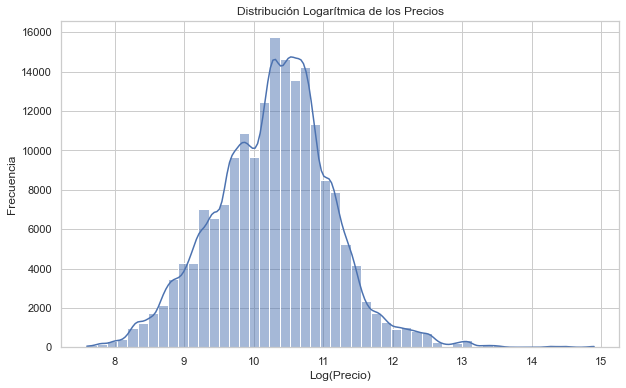

In [29]:
sns.set(style="whitegrid")

# Aplicación del logaritmo y visualización de la distribución
plt.figure(figsize=(10, 6))
sns.histplot(np.log(train_df['price']), bins=50, kde=True)
plt.title('Distribución Logarítmica de los Precios')
plt.xlabel('Log(Precio)')
plt.ylabel('Frecuencia')
plt.show()


El gráfico ilustra la cantidad de vehículos disponibles según diferentes marcas, mostrando una clara jerarquía en la popularidad y presencia de cada fabricante en el mercado.

Algunas marcas, como Ford, Mercedes-Benz, y BMW, destacan significativamente con un alto número de vehículos. Esto sugiere que estas marcas tienen una fuerte aceptación en el mercado, posiblemente debido a su reputación, calidad, y estrategias de marketing efectivas.

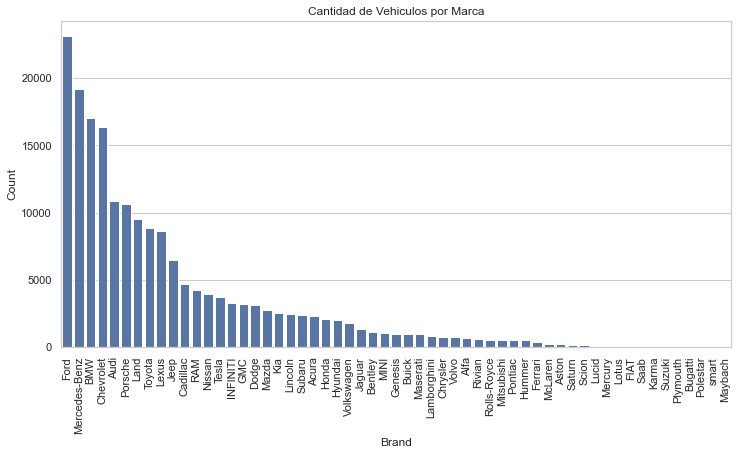

In [30]:
plt.figure(figsize=(12, 6))
sns.countplot(data=train_df, x='brand', order=train_df['brand'].value_counts().index)
plt.title('Cantidad de Vehiculos por Marca')
plt.xticks(rotation=90)
plt.xlabel('Brand')
plt.ylabel('Count')
plt.show()

El gráfico muestra la correlación entre dos variables: milage (kilometraje) y price (precio).

Correlación entre milage y price: El valor de -0.28 sugiere una correlación negativa moderada. Esto significa que, en general, a medida que aumenta el kilometraje de un vehículo, su precio tiende a disminuir. Esta tendencia es común en el mercado automotriz, ya que un mayor kilometraje generalmente se asocia con un desgaste mayor del vehículo.

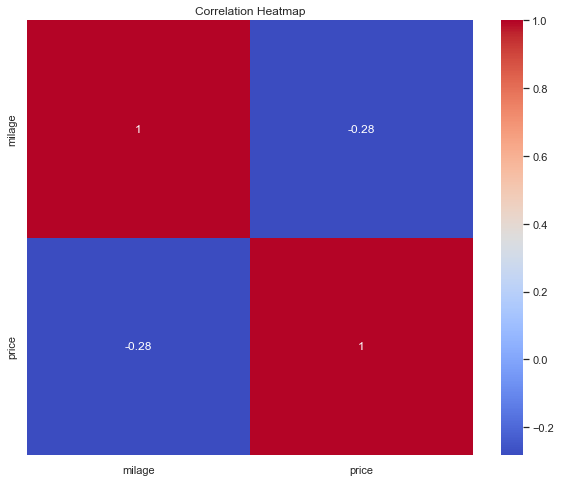

In [31]:
plt.figure(figsize=(10, 8))
corr = train_df[['milage', 'price']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


**Price vs Milage**

- La mayoría de los puntos se concentran en el rango de precios bajos (debajo de 0.5 millones) y kilometrajes por debajo de los 150,000 km. Hay varios vehículos con precios superiores a 1 millón, pero estos tienden a tener un kilometraje más bajo.

- Se observan algunos puntos con precios significativamente altos (2-3 millones), incluso para vehículos con kilometrajes altos (por encima de 100,000 km). Esto podría sugerir vehículos de lujo o ediciones especiales que mantienen su valor a pesar de su uso.

- En general, parece que a medida que el kilometraje aumenta, el precio tiende a reducirse. Esta es una tendencia lógica ya que los vehículos con mayor kilometraje suelen tener más desgaste y, por tanto, un valor de reventa más bajo.

- Hay algunos puntos con precios muy bajos y kilometrajes extremadamente altos (más de 350,000 km). Estos podrían representar vehículos muy antiguos o en malas condiciones, lo cual podría merecer más análisis para eliminar outliers o corroborar datos.

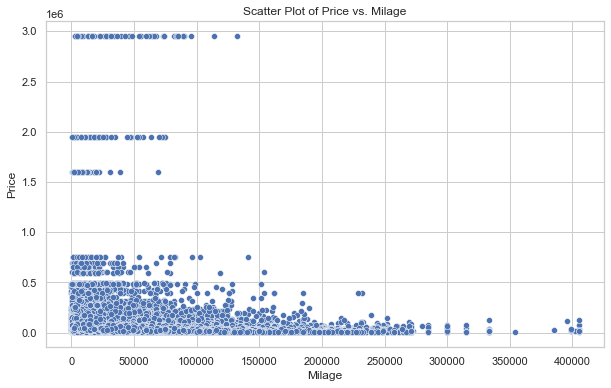

In [32]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='milage', y='price', data=train_df)
plt.title('Scatter Plot of Price vs. Milage')
plt.xlabel('Milage')
plt.ylabel('Price')
plt.show()

**Model Year vs Price**

Existe una correlación moderada entre el año del modelo y el precio: los vehículos más nuevos (posteriores a 2010) tienden a tener precios más altos.
Vehículos anteriores a 1990 tienden a tener precios muy bajos, lo cual es esperable debido a la antigüedad de estos modelos.

- Vehículos con precios altos:

Hay vehículos relativamente recientes (después del año 2000) con precios que supera 1.5. Esto podría ser indicativo de modelos de lujo, autos eléctricos de gama alta o ediciones limitadas.
También se observa que algunos vehículos antiguos (de antes del 2000) pueden alcanzar precios superiores a los 2 millones, posiblemente debido a que se trata de autos clásicos o de colección.

- Concentración de puntos:

Una gran cantidad de puntos se agrupa en el rango de precios bajos (por debajo de 0.5) y en los años más recientes (posteriores a 2010), lo que podría corresponder a vehículos de gama media o baja con más disponibilidad en el mercado.
El gráfico sugiere que hay un número considerable de vehículos nuevos que se venden a precios accesibles (debajo de 0.5).

- Outliers:

Hay algunos puntos dispersos que presentan precios extremadamente bajos o altos para su año de fabricación, lo cual podría ser un buen lugar para realizar un análisis más profundo de outliers.

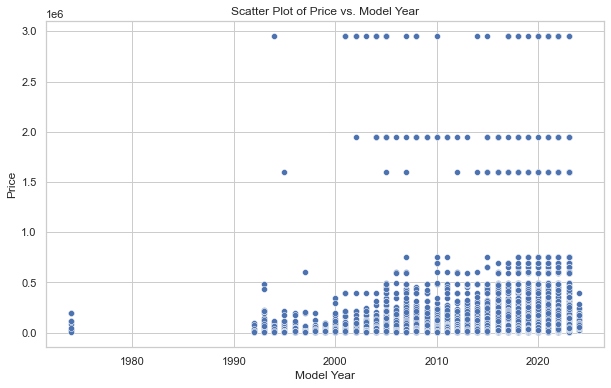

In [38]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='model_year', y='price', data=train_df)
plt.title('Scatter Plot of Price vs. Model Year')
plt.xlabel('Model Year')
plt.ylabel('Price')
plt.show()

**Distribución de Precios por Tipo de Combustible**
 
- Para todos los tipos de combustible, la mayor parte de los precios se concentra por debajo de 0.5 millones, como se observa en la parte inferior de las cajas. Sin embargo, hay outliers que superan el millón en la mayoría de las categorías.


- El combustible más común es la gasolina, que presenta una amplia distribución de precios, con algunos outliers que alcanzan los 3 millones.
El tipo E85 Flex Fuel y diésel también tienen una alta densidad de precios en el rango bajo, con algunos precios elevados, pero no tan extremos como los de gasolina.


- Los vehículos híbridos y plug-in híbridos muestran una distribución más concentrada, especialmente en el caso de los plug-in híbridos, donde los precios parecen ser más bajos en comparación con otros tipos de combustible.
Los híbridos tienen algunos outliers, pero su rango intercuartil es similar al de los vehículos de gasolina, lo que sugiere que pueden ser competitivos en precio.

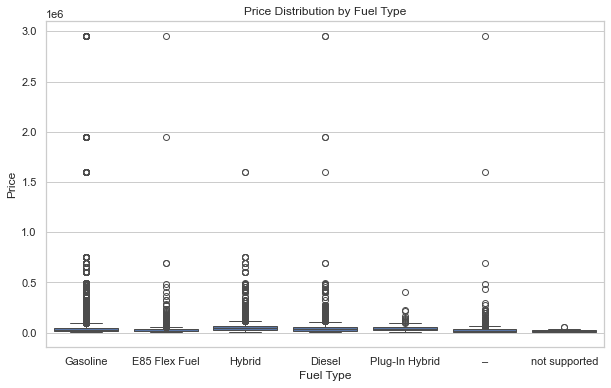

In [18]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='fuel_type', y='price', data=train_df)
plt.title('Price Distribution by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Price')
plt.show()

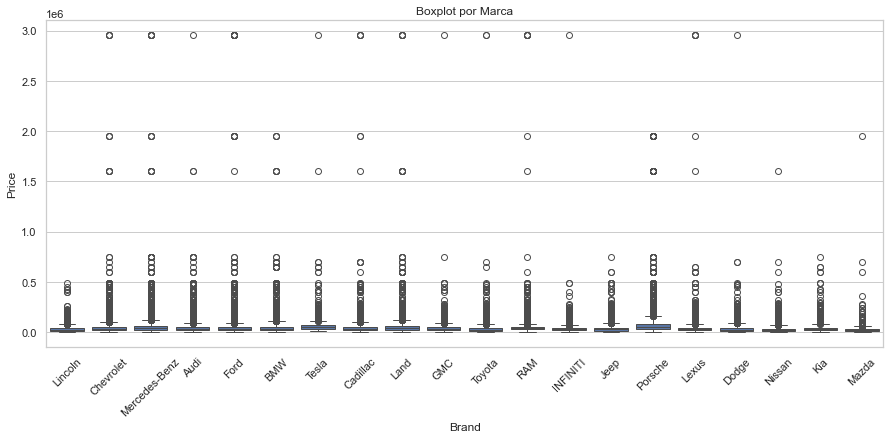

In [20]:
# Contar las marcas y seleccionar las 20 más comunes
top_brands = train_df['brand'].value_counts().nlargest(20).index

# Filtrar el DataFrame para que solo incluya las marcas seleccionadas
filtered_df = train_df[train_df['brand'].isin(top_brands)]

plt.figure(figsize=(15, 6))
sns.boxplot(x='brand', y='price', data=filtered_df)
plt.title('Boxplot por Marca')
plt.xlabel('Brand')
plt.ylabel('Price')
plt.xticks(rotation=45) 
plt.show()

In [39]:
train_df['brand'].value_counts()

brand
Ford             23088
Mercedes-Benz    19172
BMW              17028
Chevrolet        16335
Audi             10887
Porsche          10612
Land              9525
Toyota            8850
Lexus             8643
Jeep              6474
Cadillac          4674
RAM               4249
Nissan            3930
Tesla             3738
INFINITI          3276
GMC               3215
Dodge             3133
Mazda             2719
Kia               2497
Lincoln           2423
Subaru            2381
Acura             2282
Honda             2101
Hyundai           2045
Volkswagen        1765
Jaguar            1319
Bentley           1155
MINI              1064
Genesis            969
Buick              940
Maserati           939
Lamborghini        809
Chrysler           727
Volvo              723
Alfa               682
Rivian             590
Rolls-Royce        561
Mitsubishi         551
Pontiac            538
Hummer             520
Ferrari            359
McLaren            243
Aston              238
Satur

In [22]:
# Calcular las estadísticas: media, mínimo y máximo por marca
stats = train_df.groupby('brand')['price'].agg(['mean', 'min', 'max'])

# Transponer el DataFrame para que cada columna sea una marca
stats = stats.transpose()

# Establecer nombres de las filas
stats.index = ['Mean', 'Min', 'Max']

# Mostrar el cuadro de estadísticas
stats

brand,Acura,Alfa,Aston,Audi,BMW,Bentley,Bugatti,Buick,Cadillac,Chevrolet,...,Saab,Saturn,Scion,Subaru,Suzuki,Tesla,Toyota,Volkswagen,Volvo,smart
Mean,28628.496494,51993.095308,1.123646e+05,4.100486e+04,4.365978e+04,1.292729e+05,169600.0,29617.835106,4.565909e+04,4.183676e+04,...,28594.0,18204.236486,14652.416667,21521.107938,30124.75,5.644527e+04,2.914781e+04,26339.422663,30879.215768,34664.0
Min,2000.000000,3000.000000,3.850000e+03,2.000000e+03,2.000000e+03,2.300000e+03,67900.0,3200.000000,2.000000e+03,2.000000e+03,...,2900.0,3850.000000,2900.000000,2900.000000,8900.00,5.500000e+03,2.000000e+03,2000.000000,2000.000000,9000.0
Max,489995.000000,649999.000000,2.954083e+06,2.954083e+06,1.950995e+06,2.954083e+06,259500.0,449991.000000,2.954083e+06,2.954083e+06,...,75500.0,200000.000000,42850.000000,479995.000000,101999.00,2.954083e+06,2.954083e+06,599995.000000,489000.000000,84997.0


In [38]:
train_df['ext_col'].value_counts()

ext_col
Black                                 48658
White                                 43815
Gray                                  25293
Silver                                16995
Blue                                  14555
                                      ...  
GT SILVER                                 5
Blue Caelum                               5
Granite Crystal Metallic Clearcoat        5
BLUE                                      3
Mango Tango Pearlcoat                     2
Name: count, Length: 319, dtype: int64

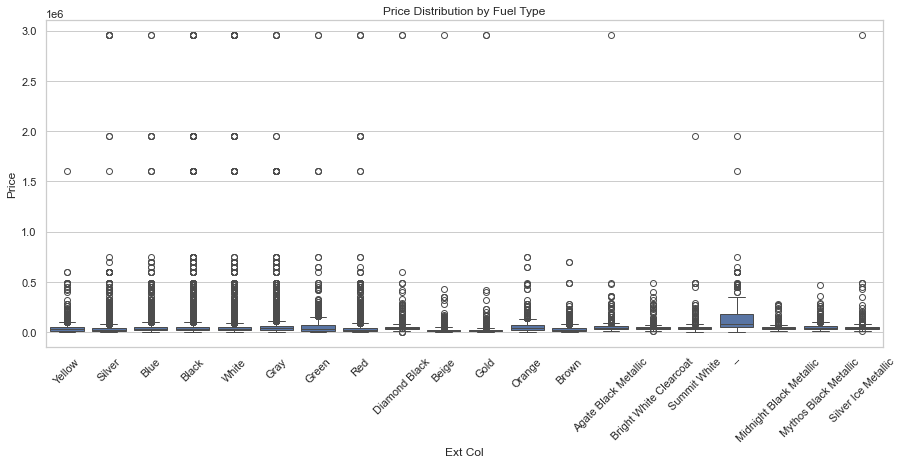

In [24]:
# Contar las categorías de combustible y seleccionar las 20 más comunes
top_ext_col = train_df['ext_col'].value_counts().nlargest(20).index

# Filtrar el DataFrame para que solo incluya los tipos de combustible seleccionados
filtered_df = train_df[train_df['ext_col'].isin(top_ext_col)]

# Crear el boxplot
plt.figure(figsize=(15, 6))
sns.boxplot(x='ext_col', y='price', data=filtered_df)
plt.title('Price Distribution by Fuel Type')
plt.xlabel('Ext Col')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotar etiquetas del eje x para mejor visibilidad
plt.show()

In [40]:
train_df['int_col'].value_counts()

int_col
Black           107674
Beige            24495
Gray             21204
Brown             5810
Red               5145
                 ...  
Nougat Brown         7
Classic Red          7
Cobalt Blue          6
WHITE                6
ORANGE               4
Name: count, Length: 156, dtype: int64

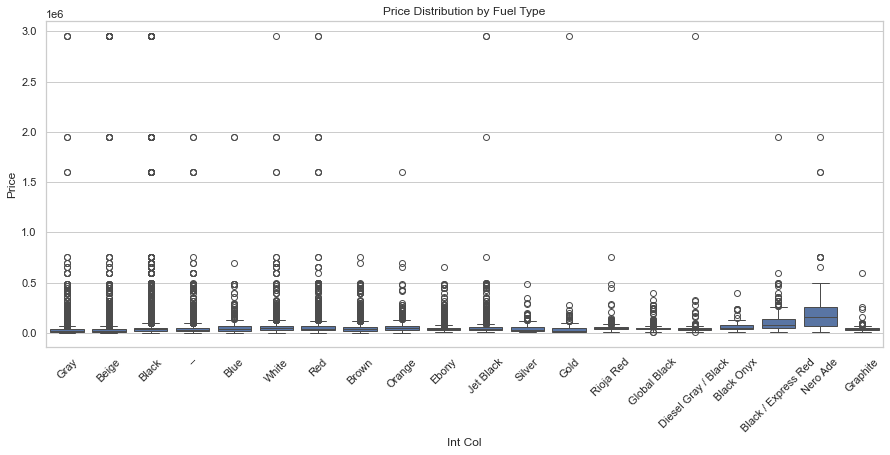

In [26]:
# Contar las categorías y seleccionar las 20 más comunes
top_int_col = train_df['int_col'].value_counts().nlargest(20).index

# Filtrar el DataFrame para incluir solo los tipos seleccionados
filtered_df = train_df[train_df['int_col'].isin(top_int_col)]

# Crear el boxplot
plt.figure(figsize=(15, 6))
sns.boxplot(x='int_col', y='price', data=filtered_df)
plt.title('Price Distribution by Fuel Type')
plt.xlabel('Int Col')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotar etiquetas del eje x para mejor visibilidad
plt.show()

In [42]:
train_df['clean_title'].value_counts()

clean_title
Yes    188533
Name: count, dtype: int64